In [1]:
!nvidia-smi

Fri May  5 04:17:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1E.0 Off |                    0 |
| N/A   30C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install ultralytics==8.0.28
!pip install gdown 

from IPython import display
display.clear_output()


In [ ]:

import ultralytics
ultralytics.checks()
     

Ultralytics YOLOv8.0.28 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
Setup complete ✅ (8 CPUs, 59.9 GB RAM, 26.4/193.8 GB disk)


In [ ]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device,torch.cuda.is_available())


cuda True


In [ ]:
import gdown
import zipfile
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2


Dataset_name = "Can"


if Dataset_name == "Can":
    # # same as the above, but with the file ID
     id = "1Z8jqT-bVgI346gKY0vmbRM6_ytx3bFFY"
     zip_output = "datasets.zip"

    


if not os.path.isdir( "datasets" ):
    gdown.download(id=id, output= zip_output, quiet=False)
    with zipfile.ZipFile(zip_output, 'r') as zip_ref:
        zip_ref.extractall('.')
    
    # delete zip file
    #os.remove(zip_output)    

Downloading...
From (uriginal): https://drive.google.com/uc?id=1Z8jqT-bVgI346gKY0vmbRM6_ytx3bFFY
From (redirected): https://drive.google.com/uc?id=1Z8jqT-bVgI346gKY0vmbRM6_ytx3bFFY&confirm=t&uuid=0e630430-b533-4bb7-8c43-33983189476a
To: /home/ubuntu/yolo/datasets.zip
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.97G/2.97G [00:12<00:00, 247MB/s]


# Scan Dataset



In [3]:
import os
import fnmatch
import json
import pandas as pd
from tqdm import tqdm

def find_json_files(root):
    L = []
    for path, dirs, files in os.walk(root):
        for filename in fnmatch.filter(files, '*.json'):
            L.append( os.path.join(path, filename))
    return L        

def find_images_from_Ljson(json_Lfiles) :
    L = []
    for json_file in json_Lfiles:
      image_path = json_file.replace('json','jpg')
      if  os.path.exists(image_path):
          L.append(image_path)
    return L      

def find_labels(file_json,file_image ) :
    Label = []
    for file_json,file_image in zip(json_Lfiles,image_Lfiles) :
        if "Anormal" in file_json and "Anormal" in file_image:
           Label.append("Anormal") 
        else :
           Label.append("Normal")
    return Label



root = "Raw_Can_Dataset"

json_Lfiles   = find_json_files(root)
image_Lfiles  = find_images_from_Ljson(json_Lfiles)
L_Label       = find_labels(json_Lfiles,image_Lfiles)

if len(json_Lfiles) != len(image_Lfiles):
    print("Error: Number of json Files and Number of Image are not equal")

print("Number of json Files: ", len(json_Lfiles)," Number of Image : ", len(image_Lfiles))

df = pd.DataFrame({"Image_path":image_Lfiles,"Json_path":json_Lfiles,"Label":L_Label})

df

Number of json Files:  974  Number of Image :  974


Image_path  \
0                 Raw_Can_Dataset/Normal4/IMG_4393.jpg   
1                 Raw_Can_Dataset/Normal4/IMG_4360.jpg   
2                 Raw_Can_Dataset/Normal4/IMG_4358.jpg   
3                 Raw_Can_Dataset/Normal4/IMG_4373.jpg   
4                 Raw_Can_Dataset/Normal4/IMG_4371.jpg   
..                                                 ...   
969  Raw_Can_Dataset/Anormal/bbd0e5ffd743ff960f1c6b...   
970  Raw_Can_Dataset/Anormal/7b8bda4ff79e0ab3a99ebf...   
971  Raw_Can_Dataset/Anormal/49d0ea4ac613037499e5ca...   
972  Raw_Can_Dataset/Anormal/791e5138f6bafe46e9e1b3...   
973  Raw_Can_Dataset/Anormal/8d0509275bd96cfdf773fe...   

                                             Json_path    Label  
0                Raw_Can_Dataset/Normal4/IMG_4393.json   Normal  
1                Raw_Can_Dataset/Normal4/IMG_4360.json   Normal  
2                Raw_Can_Dataset/Normal4/IMG_4358.json   Normal  
3                Raw_Can_Dataset/Normal4/IMG_4373.json   Normal  
4                Raw_Can_Dataset/Normal4/IMG_4371.json   Normal  
..                                                 ...      ...  
969  Raw_Can_Dataset/Anormal/bbd0e5ffd743ff960f1c6b...  Anormal  
970  Raw_Can_Dataset/Anormal/7b8bda4ff79e0ab3a99ebf...  Anormal  
971  Raw_Can_Dataset/Anormal/49d0ea4ac613037499e5ca...  Anormal  
972  Raw_Can_Dataset/Anormal/791e5138f6bafe46e9e1b3...  Anormal  
973  Raw_Can_Dataset/Anormal/8d0509275bd96cfdf773fe...  Anormal  

[974 rows x 3 columns]

Normal     601
Anormal    373
Name: Label, dtype: int64

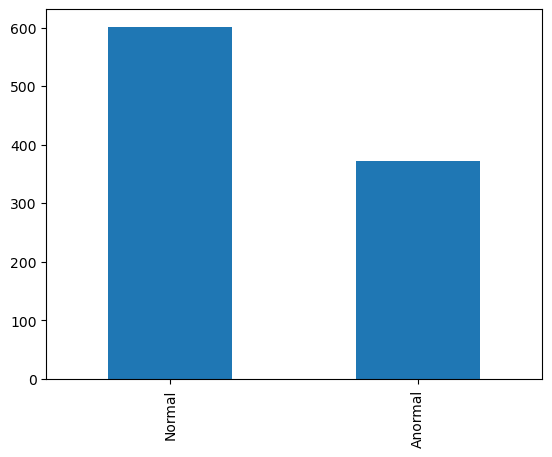

In [4]:
df['Label'].value_counts().plot(kind='bar')
df['Label'].value_counts()

# Train_Test Spit

In [5]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold


# specify the number of folds you want to create
n_splits = 5

# create an instance of StratifiedKFold with the desired number of splits
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# iterate over the folds and split your dataset into training and testing sets
for fold, (train_index, test_index) in enumerate(skf.split(df, df["Label"])):
    train_data = df.iloc[train_index]
    test_data = df.iloc[test_index]
    # do something with the training and testing data for this fold
    # for example, train a machine learning model on the training data and evaluate it on the testing data

In [6]:
 train_data

Image_path  \
0                 Raw_Can_Dataset/Normal4/IMG_4393.jpg   
1                 Raw_Can_Dataset/Normal4/IMG_4360.jpg   
3                 Raw_Can_Dataset/Normal4/IMG_4373.jpg   
4                 Raw_Can_Dataset/Normal4/IMG_4371.jpg   
5                 Raw_Can_Dataset/Normal4/IMG_4378.jpg   
..                                                 ...   
969  Raw_Can_Dataset/Anormal/bbd0e5ffd743ff960f1c6b...   
970  Raw_Can_Dataset/Anormal/7b8bda4ff79e0ab3a99ebf...   
971  Raw_Can_Dataset/Anormal/49d0ea4ac613037499e5ca...   
972  Raw_Can_Dataset/Anormal/791e5138f6bafe46e9e1b3...   
973  Raw_Can_Dataset/Anormal/8d0509275bd96cfdf773fe...   

                                             Json_path    Label  
0                Raw_Can_Dataset/Normal4/IMG_4393.json   Normal  
1                Raw_Can_Dataset/Normal4/IMG_4360.json   Normal  
3                Raw_Can_Dataset/Normal4/IMG_4373.json   Normal  
4                Raw_Can_Dataset/Normal4/IMG_4371.json   Normal  
5                Raw_Can_Dataset/Normal4/IMG_4378.json   Normal  
..                                                 ...      ...  
969  Raw_Can_Dataset/Anormal/bbd0e5ffd743ff960f1c6b...  Anormal  
970  Raw_Can_Dataset/Anormal/7b8bda4ff79e0ab3a99ebf...  Anormal  
971  Raw_Can_Dataset/Anormal/49d0ea4ac613037499e5ca...  Anormal  
972  Raw_Can_Dataset/Anormal/791e5138f6bafe46e9e1b3...  Anormal  
973  Raw_Can_Dataset/Anormal/8d0509275bd96cfdf773fe...  Anormal  

[780 rows x 3 columns]

In [7]:
test_data

Image_path  \
2                 Raw_Can_Dataset/Normal4/IMG_4358.jpg   
13                Raw_Can_Dataset/Normal4/IMG_4411.jpg   
21                Raw_Can_Dataset/Normal4/IMG_4383.jpg   
22                Raw_Can_Dataset/Normal4/IMG_4382.jpg   
23                Raw_Can_Dataset/Normal4/IMG_4402.jpg   
..                                                 ...   
951  Raw_Can_Dataset/Anormal/c7b8440002448a5c9a2806...   
953  Raw_Can_Dataset/Anormal/1ff633bae5c16284fa18a2...   
955  Raw_Can_Dataset/Anormal/0214d0dcbe839c7519b19c...   
956  Raw_Can_Dataset/Anormal/f5ca756632f9d86ca45821...   
958  Raw_Can_Dataset/Anormal/34bf16f99fbe4a30b65c95...   

                                             Json_path    Label  
2                Raw_Can_Dataset/Normal4/IMG_4358.json   Normal  
13               Raw_Can_Dataset/Normal4/IMG_4411.json   Normal  
21               Raw_Can_Dataset/Normal4/IMG_4383.json   Normal  
22               Raw_Can_Dataset/Normal4/IMG_4382.json   Normal  
23               Raw_Can_Dataset/Normal4/IMG_4402.json   Normal  
..                                                 ...      ...  
951  Raw_Can_Dataset/Anormal/c7b8440002448a5c9a2806...  Anormal  
953  Raw_Can_Dataset/Anormal/1ff633bae5c16284fa18a2...  Anormal  
955  Raw_Can_Dataset/Anormal/0214d0dcbe839c7519b19c...  Anormal  
956  Raw_Can_Dataset/Anormal/f5ca756632f9d86ca45821...  Anormal  
958  Raw_Can_Dataset/Anormal/34bf16f99fbe4a30b65c95...  Anormal  

[194 rows x 3 columns]

In [8]:
 train_data['Label'].value_counts()

Normal     481
Anormal    299
Name: Label, dtype: int64

In [ ]:
 test_data['Label'].value_counts()

Normal     120
Anormal     74
Name: Label, dtype: int64

# Create YOLO Dataset

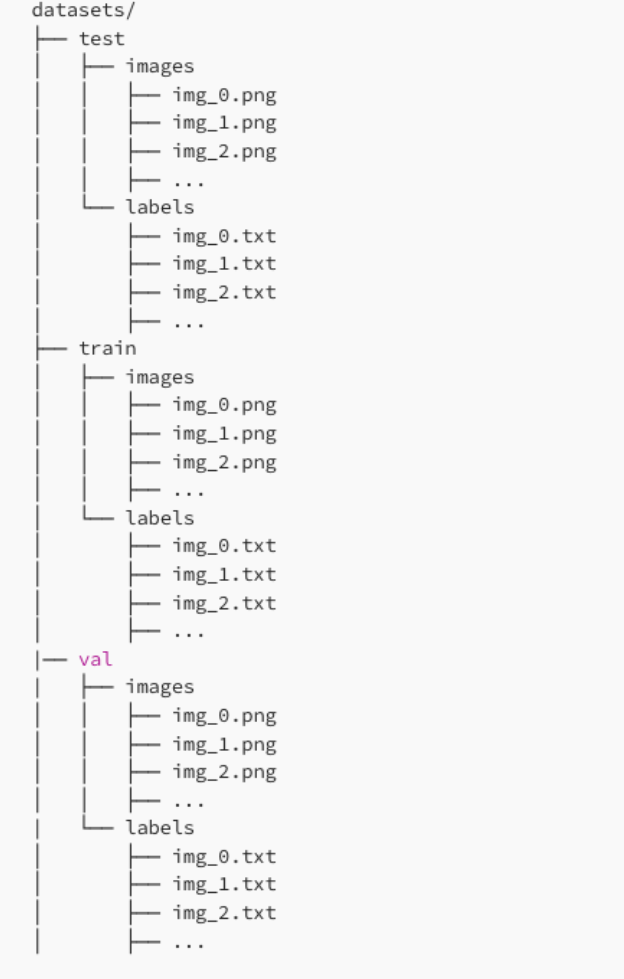

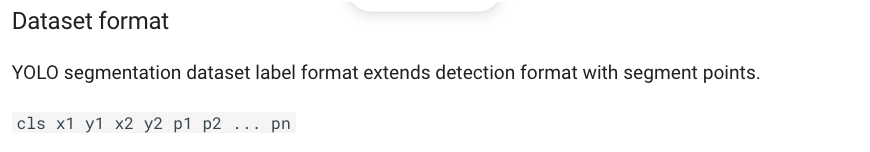

In [9]:
import os
import shutil

def bounding_box(polyline):
    min_x = float('inf')
    max_x = float('-inf')
    min_y = float('inf')
    max_y = float('-inf')
    
    for point in polyline:
        x, y = point
        if x < min_x:
            min_x = x
        if x > max_x:
            max_x = x
        if y < min_y:
            min_y = y
        if y > max_y:
            max_y = y
            
    return min_x, min_y, max_x, max_y

def json_to_save_yolo_file(jsonfile, yolo_label_txt_file):

    with open(jsonfile , 'r') as f:
            data = json.load(f)
   
    img_width = data['imageWidth']
    img_height = data['imageHeight']
    objects = data['shapes']

    yolo_lines = []
    for obj in objects:
        
        #label = obj['label']
        label = 0


        polygon = obj['points']

        min_x, min_y, max_x, max_y = bounding_box(polygon)
        min_x = min_x / img_width
        min_y = min_y / img_height
        max_x = max_x / img_width
        max_y = max_y / img_height

        yolo_polygon = []
        for p in polygon:
            x = p[0] / img_width
            y = p[1] / img_height
            yolo_polygon.append(f"{x:f} {y:f}")

        yolo_line = f"{label} {min_x} {min_y} {max_x} {max_y} {' '.join(yolo_polygon)}"
        yolo_lines.append(yolo_line)

    with open(yolo_label_txt_file, 'w') as f:
        for line in yolo_lines:
            f.write(line + '\n')
            

def image_copy(source_image_file, dest_image_file):
    shutil.copyfile(source_image_file, dest_image_file)


def Create_YOLO_Dataset(mode = "train" , df = df) :

    if os.path.exists("datasets"):
         if mode == "train" :         
            shutil.rmtree("datasets")
            print("datasets folder is deleted")
            os.mkdir("datasets")   
            print("datasets folder is created")
    else :
        os.mkdir("datasets")   
    
    
    mainfloder = f"./datasets/{mode}"
    main_image_floder = f"{mainfloder}/images"
    main_label_floder = f"{mainfloder}/labels"

    if not os.path.exists(mainfloder):
       os.mkdir(mainfloder)
    if not os.path.exists(main_image_floder):
       os.mkdir(main_image_floder)
    if not os.path.exists(main_label_floder):
      os.mkdir(main_label_floder)

    Lsource_image_files = df['Image_path'].tolist()
    Lsource_json_files  = df['Json_path'].tolist()

    Ldest_image_files = [ f"./datasets/{mode}/images/{ os.path.basename(file) }"  for file in Lsource_image_files]
    Ldest_text_files  = [ f"./datasets/{mode}/labels/{ os.path.basename(file).replace('json','txt') }"  for file in Lsource_json_files ]
    
    for source_image_file, dest_image_file in tqdm(zip(Lsource_image_files, Ldest_image_files)):
        image_copy(source_image_file, dest_image_file)
    
    for source_json_file, dest_text_file in tqdm(zip(Lsource_json_files, Ldest_text_files)):
        json_to_save_yolo_file(source_json_file, dest_text_file)

    



In [10]:

Create_YOLO_Dataset(mode="train" , df = train_data)

datasets folder is deleted
datasets folder is created


780it [00:23, 33.53it/s]
780it [00:00, 1104.40it/s]


In [11]:
Create_YOLO_Dataset(mode="test" , df = test_data)

194it [00:04, 43.55it/s]
194it [00:00, 1158.82it/s]


In [12]:
import yaml

data = {
    'train': './train/images', # Path to the directory containing training images
    'val': './test/images', # Path to the directory containing validation images
    'names': ['can']# List of class names
}

with open('dataset.yaml', 'w') as outfile:
    yaml.dump(data, outfile)

In [19]:
from ultralytics import YOLO

model = YOLO("yolov8m-seg.pt")


model_params = {
    'data': "dataset.yaml",
    'epochs': 30,
    'batch': 32,
    'imgsz': 640,
    'device': '0',
    'lr0':0.005,
    'lrf':0.005,
    'close_mosaic':5,
     'workers': 6,
     #'resume':True,

    'name': 'Y2_20.5_',
    'plots': True,
    'save': True,
    
    "hsv_h": 0.015, # image HSV-Hue augmentation (fraction)
    "hsv_s": 0.7, # image HSV-Saturation augmentation (fraction)
    "hsv_v": 0.4, # image HSV-Value augmentation (fraction)
    "degrees": 15, # image rotation (+/- deg)
    "translate": 0.35, # image translation (+/- fraction)
    "scale": 0.5, # image scale (+/- gain)
    "shear": 0, # image shear (+/- deg)
    "perspective": 0, # image perspective (+/- fraction), range 0-0.001
    "flipud": 0.5, # image flip up-down (probability)
    "fliplr": 0.5, # image flip left-right (probability)
    "mosaic": 0.5, # image mosaic (probability)
    "mixup": 0.3, # image mixup (probability)
    "copy_paste": 0.3, # segment copy-paste (probability),
    
    } 


                      
       
model_params['name'] 

'Y2_20.5_'

In [20]:


results = model.train( **model_params)
                      
                     

Ultralytics YOLOv8.0.28 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
yolo/engine/trainer: task=segment, mode=train, model=yolov8m-seg.yaml, data=dataset.yaml, epochs=30, patience=50, batch=32, imgsz=640, save=True, cache=False, device=0, workers=6, project=None, name=Y2_20.5_, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=5, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, o

# Show Results

In [21]:
Name_experimant = model_params['name']
Name_experimant

'Y2_20.5_'

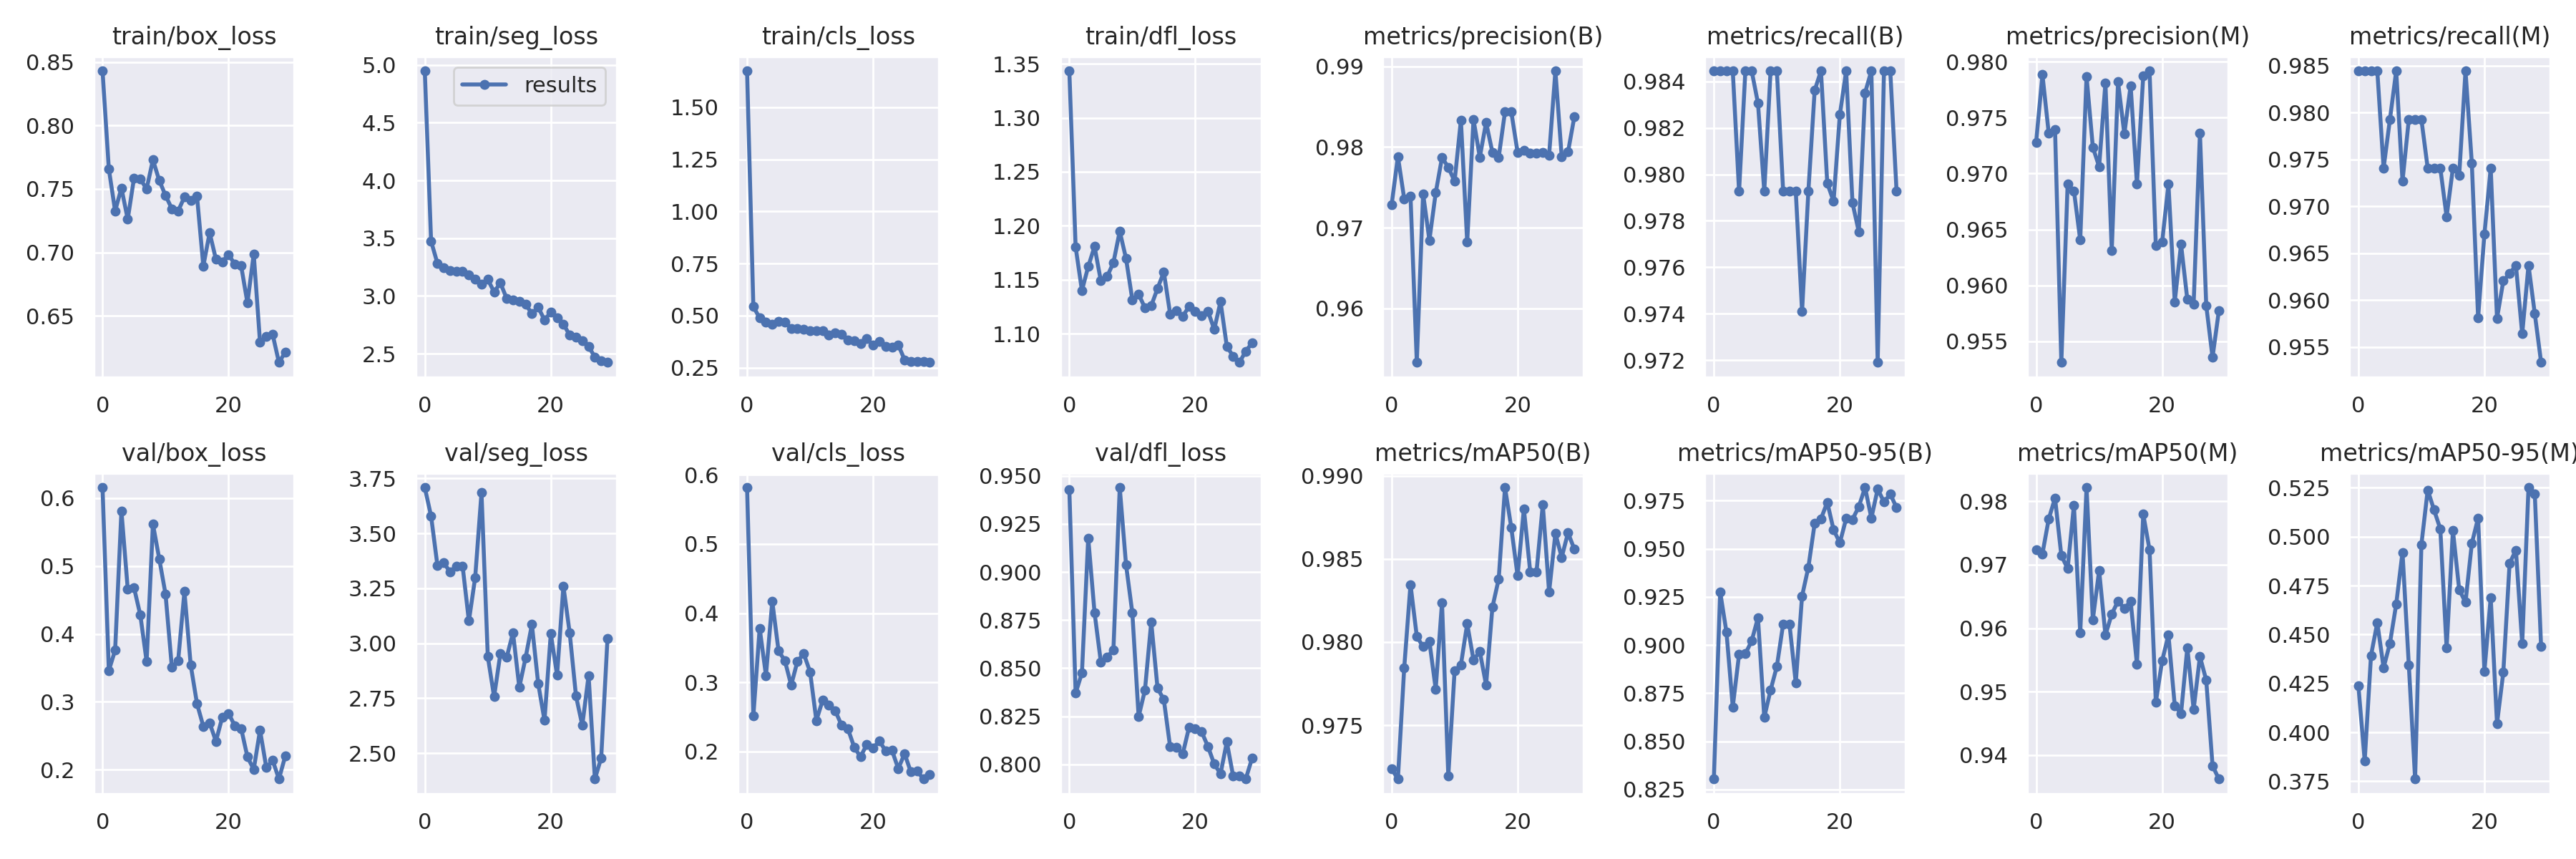

In [22]:
from IPython.display import display, Image
Image(filename=f'./runs/segment/{Name_experimant}/results.png', width=1200)

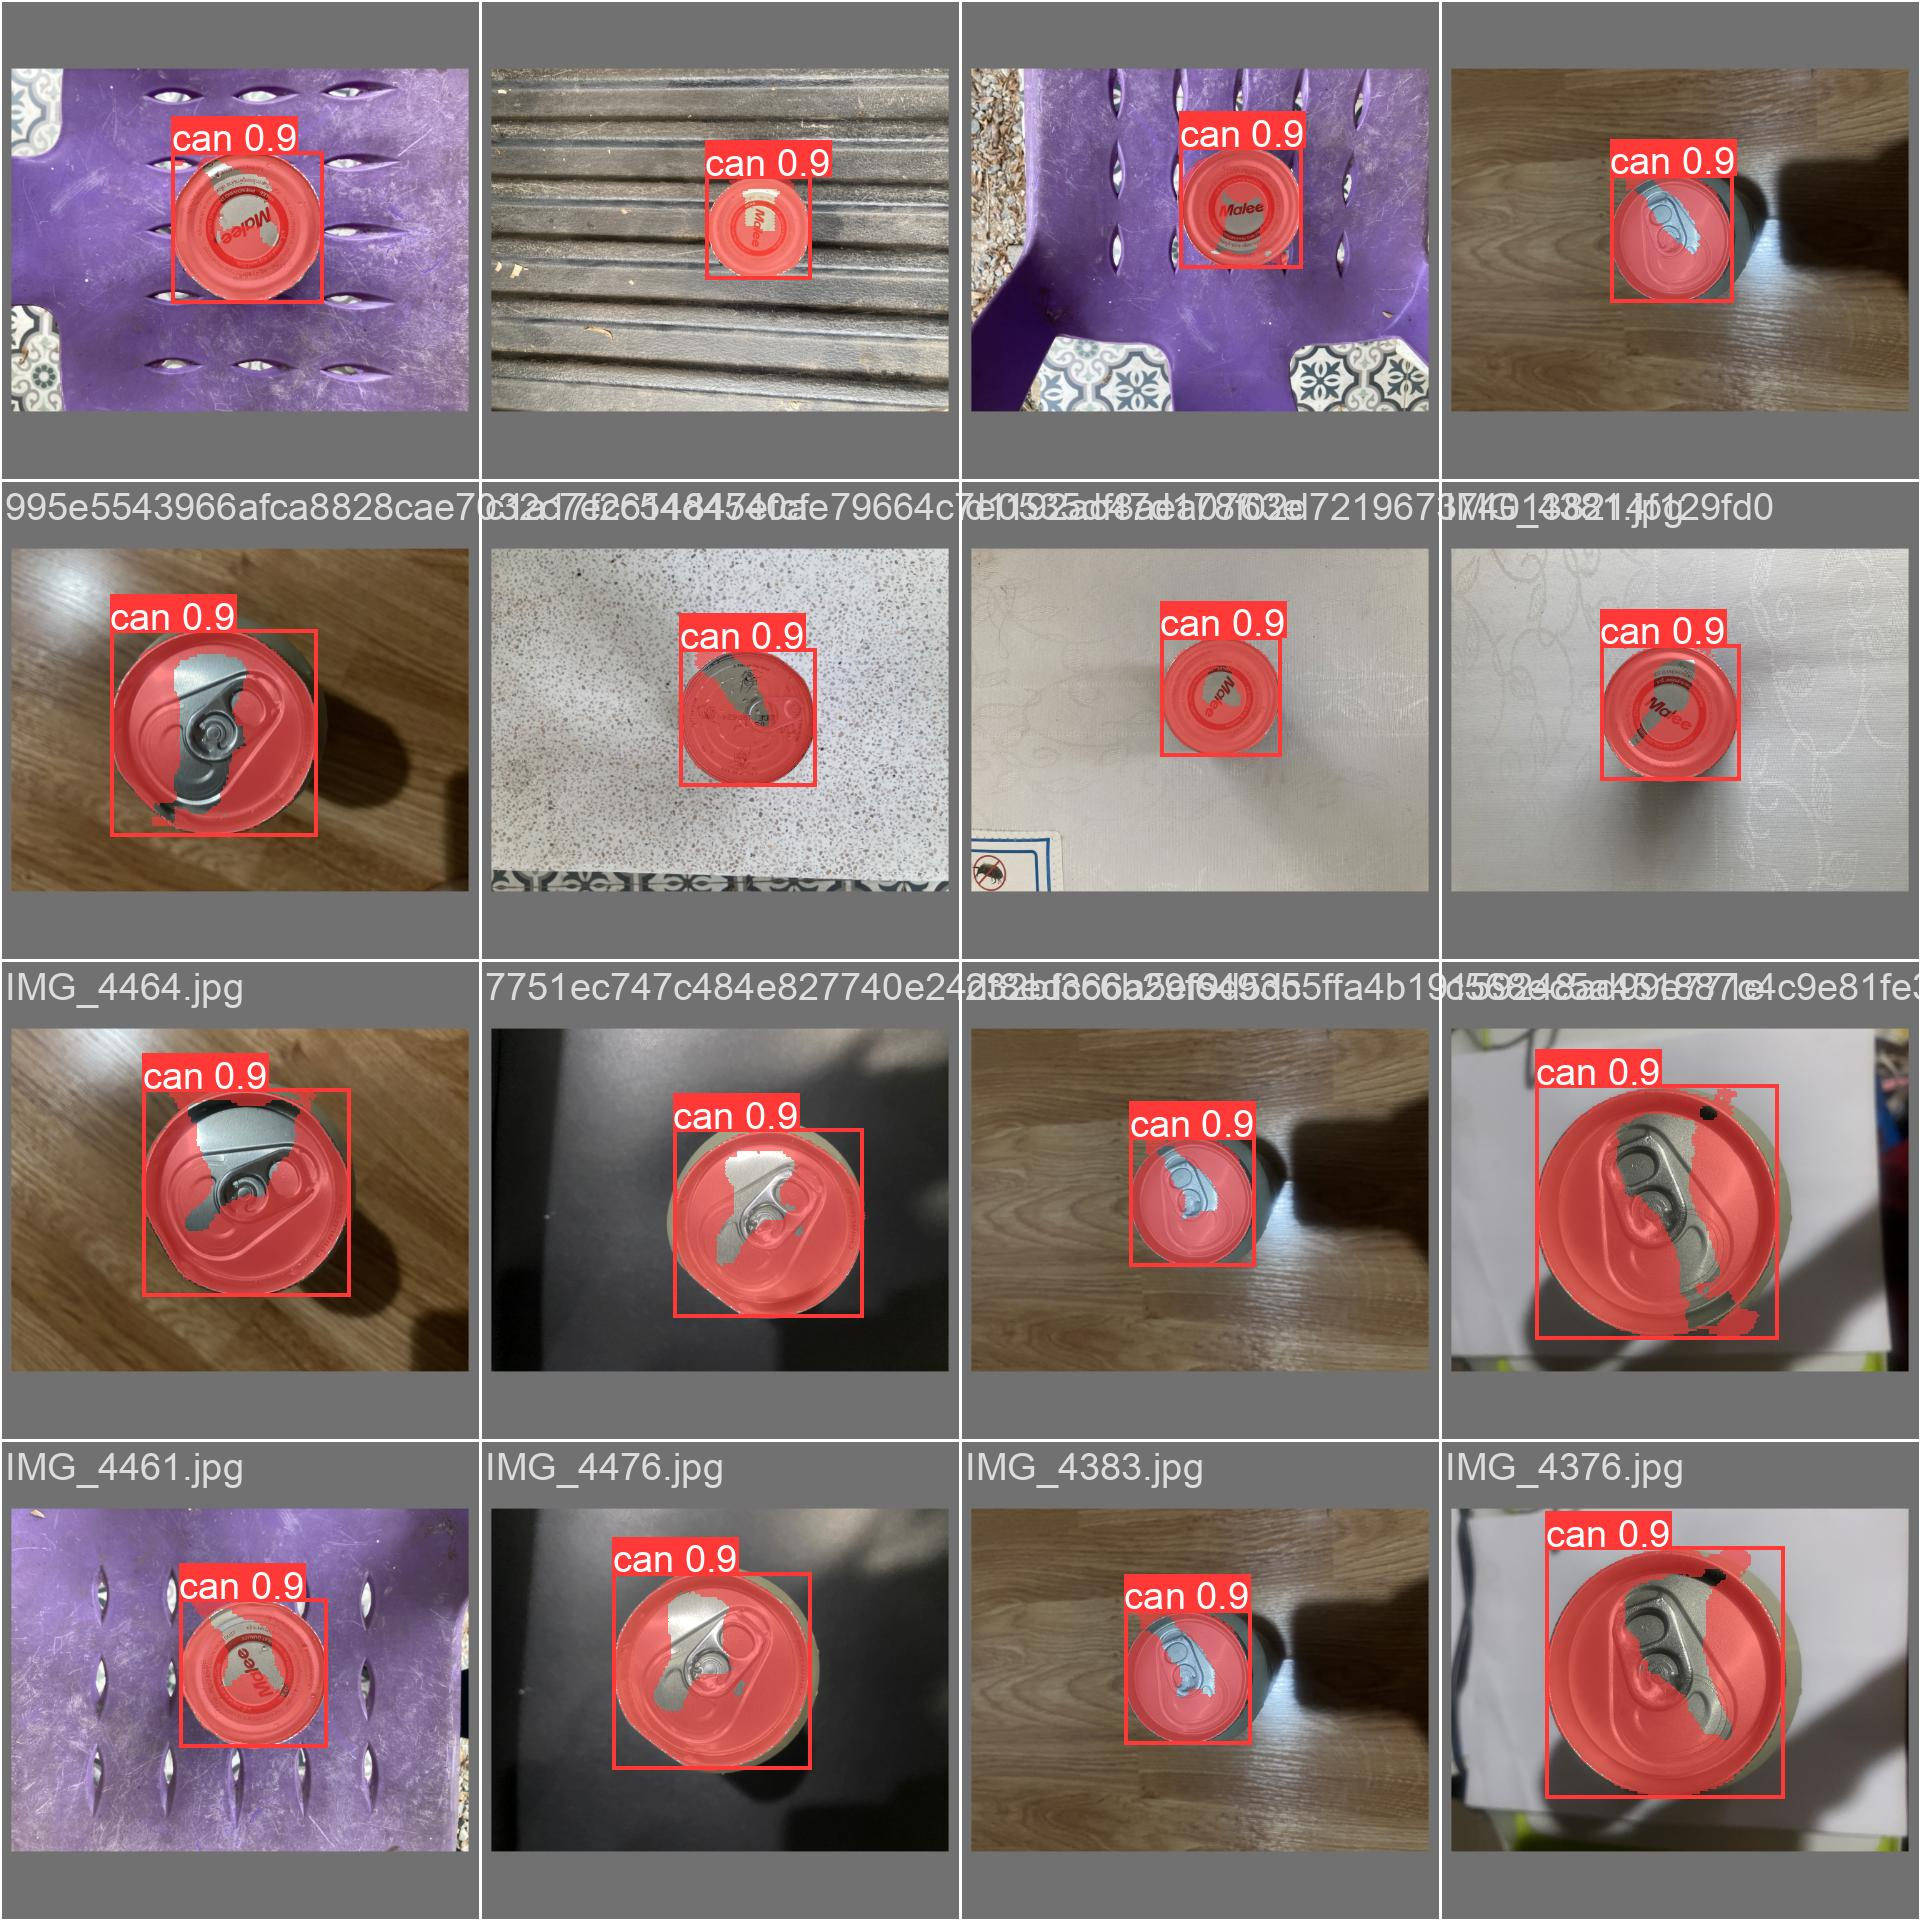

In [23]:
from IPython.display import display, Image
Image(filename=f'./runs/segment/{Name_experimant}/val_batch0_pred.jpg', width=1200)

# Varidation

In [40]:
!yolo task=detect mode=predict model=./runs/segment/Y2_20.5_/weights/best.pt conf=0.25 source=./Raw_Can_Dataset/Anormal4 save=True

WARNING ⚠️ 'task=detect' conflicts with segment model ./runs/segment/Y2_20.5_/weights/best.pt. Inheriting 'task=segment' from ./runs/segment/Y2_20.5_/weights/best.pt and ignoring 'task=detect'.
Ultralytics YOLOv8.0.28 🚀 Python-3.10.10 torch-2.0.0 CPU
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs

image 1/61 /home/ubuntu/yolo/Raw_Can_Dataset/Anormal4/IMG_4461.jpg: 480x640 1 can, 412.9ms
image 2/61 /home/ubuntu/yolo/Raw_Can_Dataset/Anormal4/IMG_4462.jpg: 480x640 1 can, 395.8ms
image 3/61 /home/ubuntu/yolo/Raw_Can_Dataset/Anormal4/IMG_4463.jpg: 480x640 1 can, 392.3ms
image 4/61 /home/ubuntu/yolo/Raw_Can_Dataset/Anormal4/IMG_4464.jpg: 480x640 1 can, 378.7ms
image 5/61 /home/ubuntu/yolo/Raw_Can_Dataset/Anormal4/IMG_4465.jpg: 576x640 1 can, 456.4ms
image 6/61 /home/ubuntu/yolo/Raw_Can_Dataset/Anormal4/IMG_4466.jpg: 480x640 1 can, 360.8ms
image 7/61 /home/ubuntu/yolo/Raw_Can_Dataset/Anormal4/IMG_4467.jpg: 480x640 1 can, 367.2ms
image 8/61 /home/ubuntu

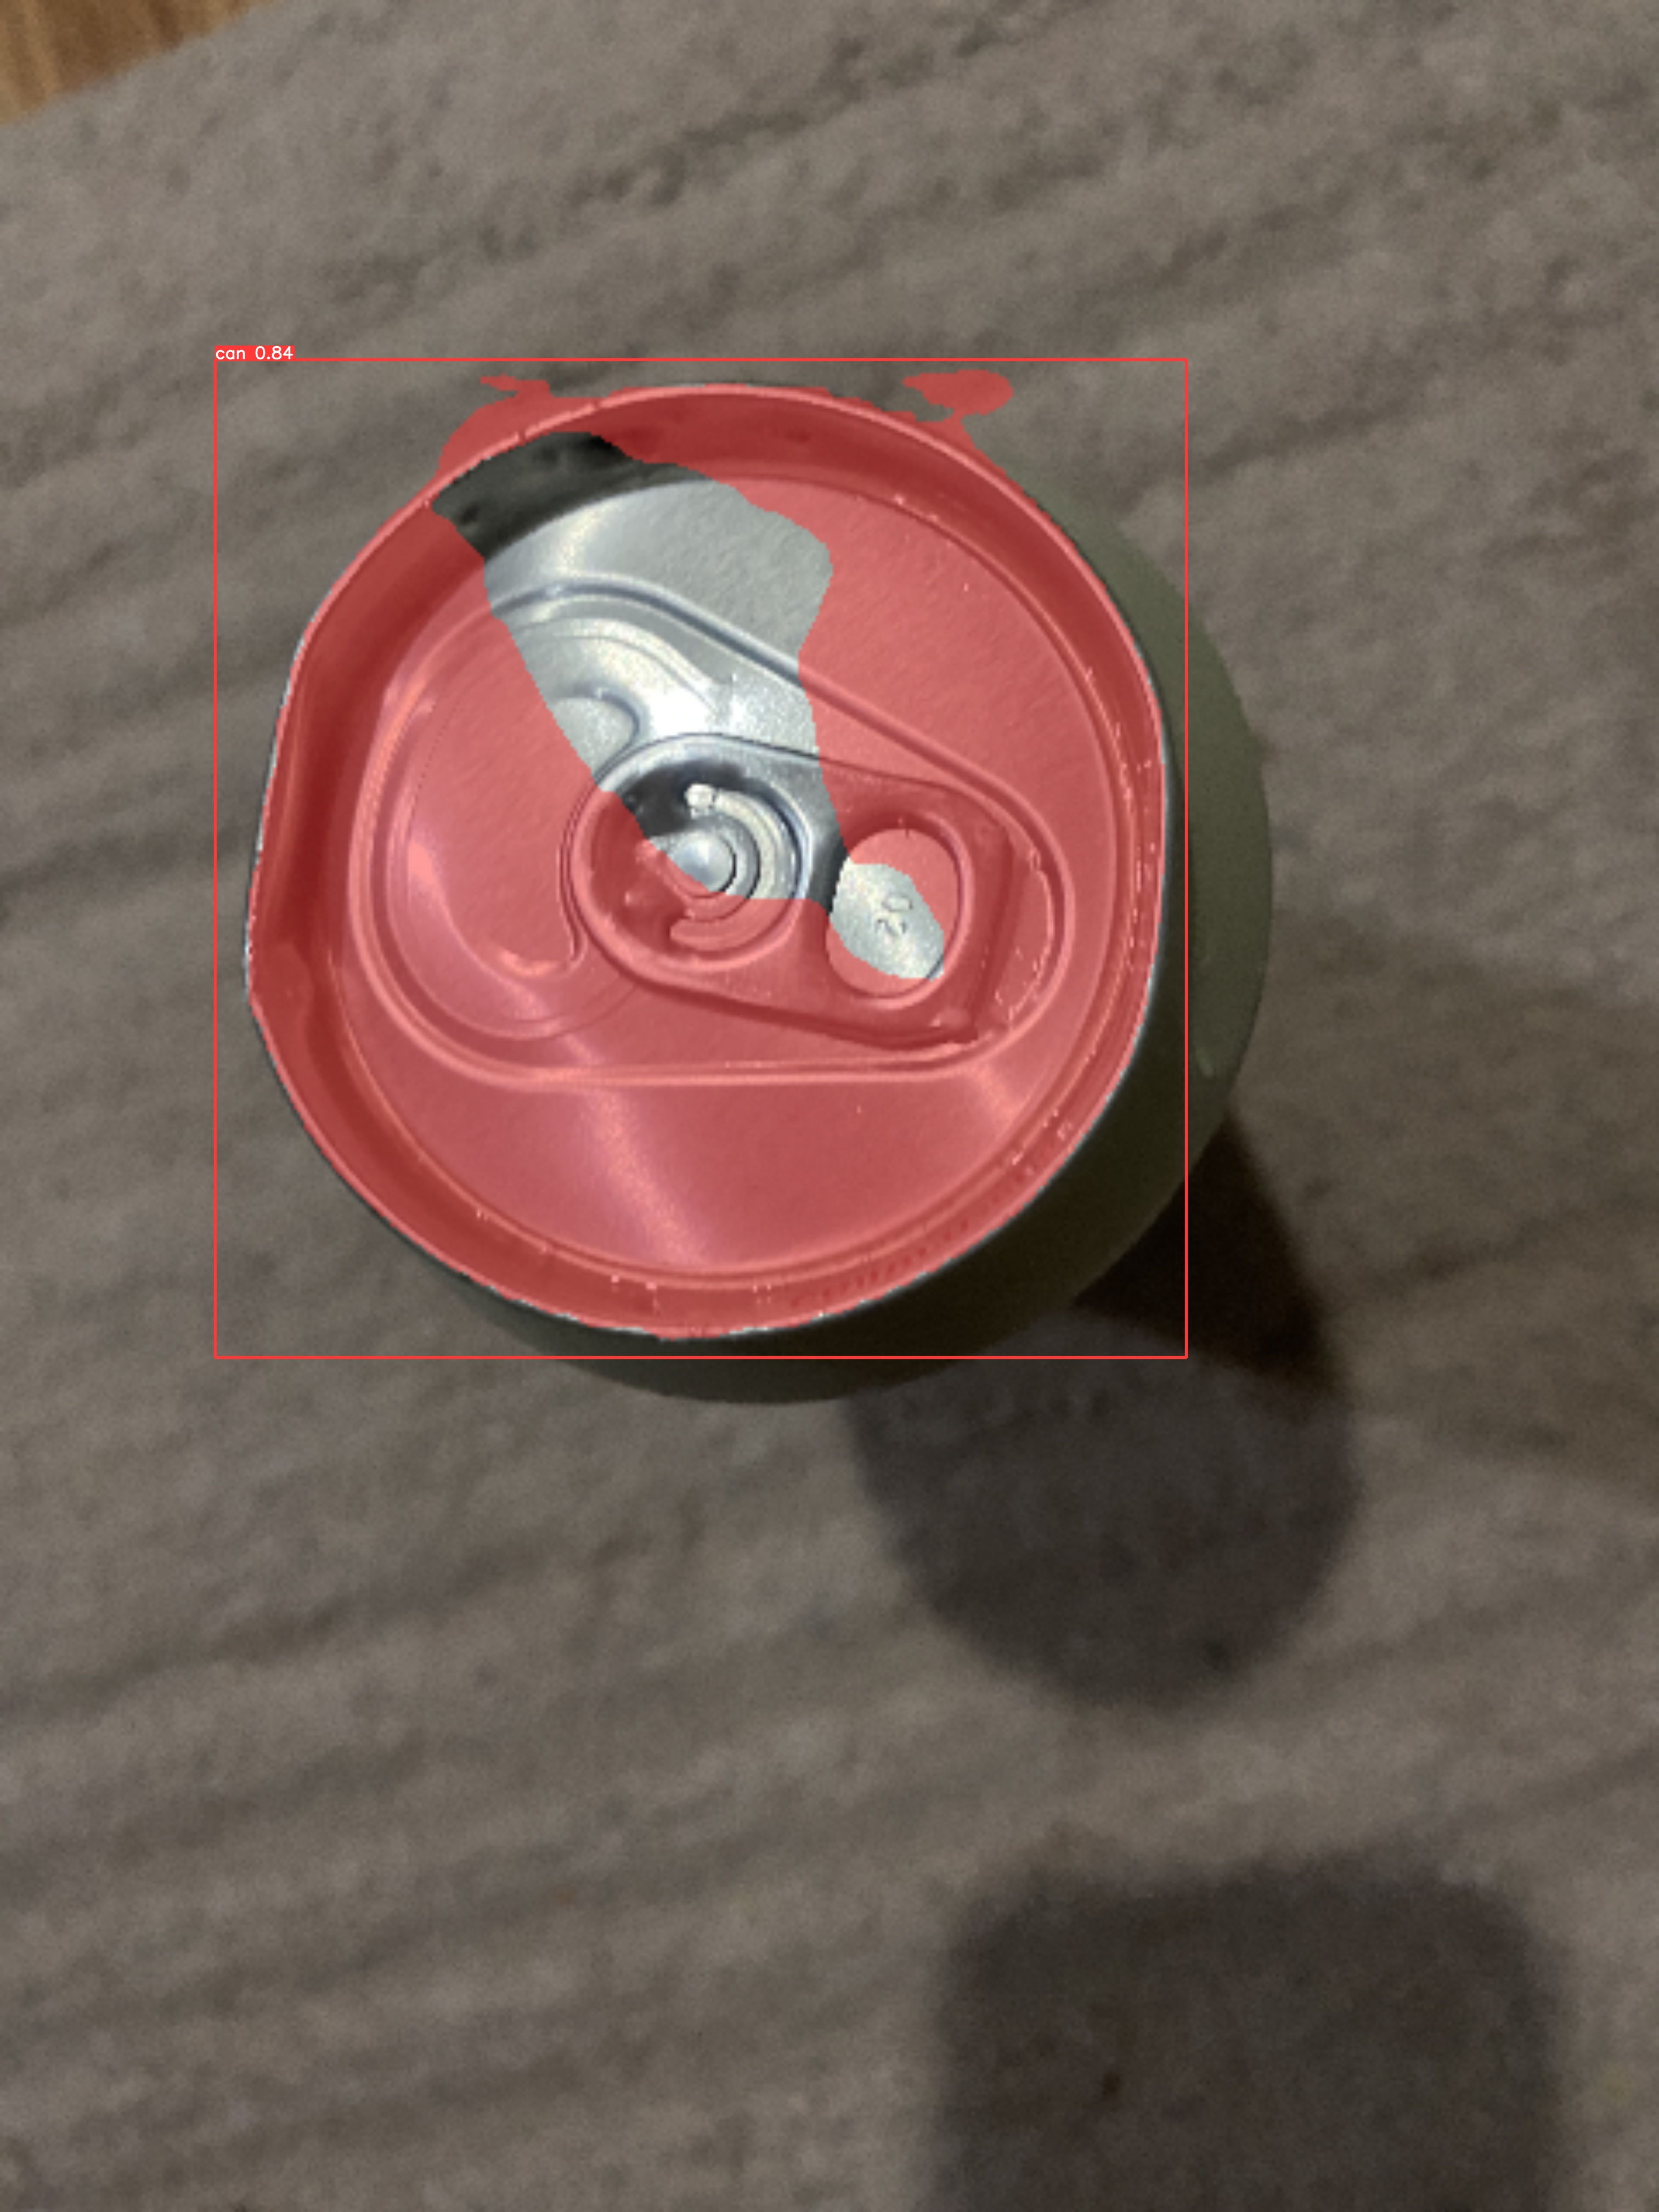

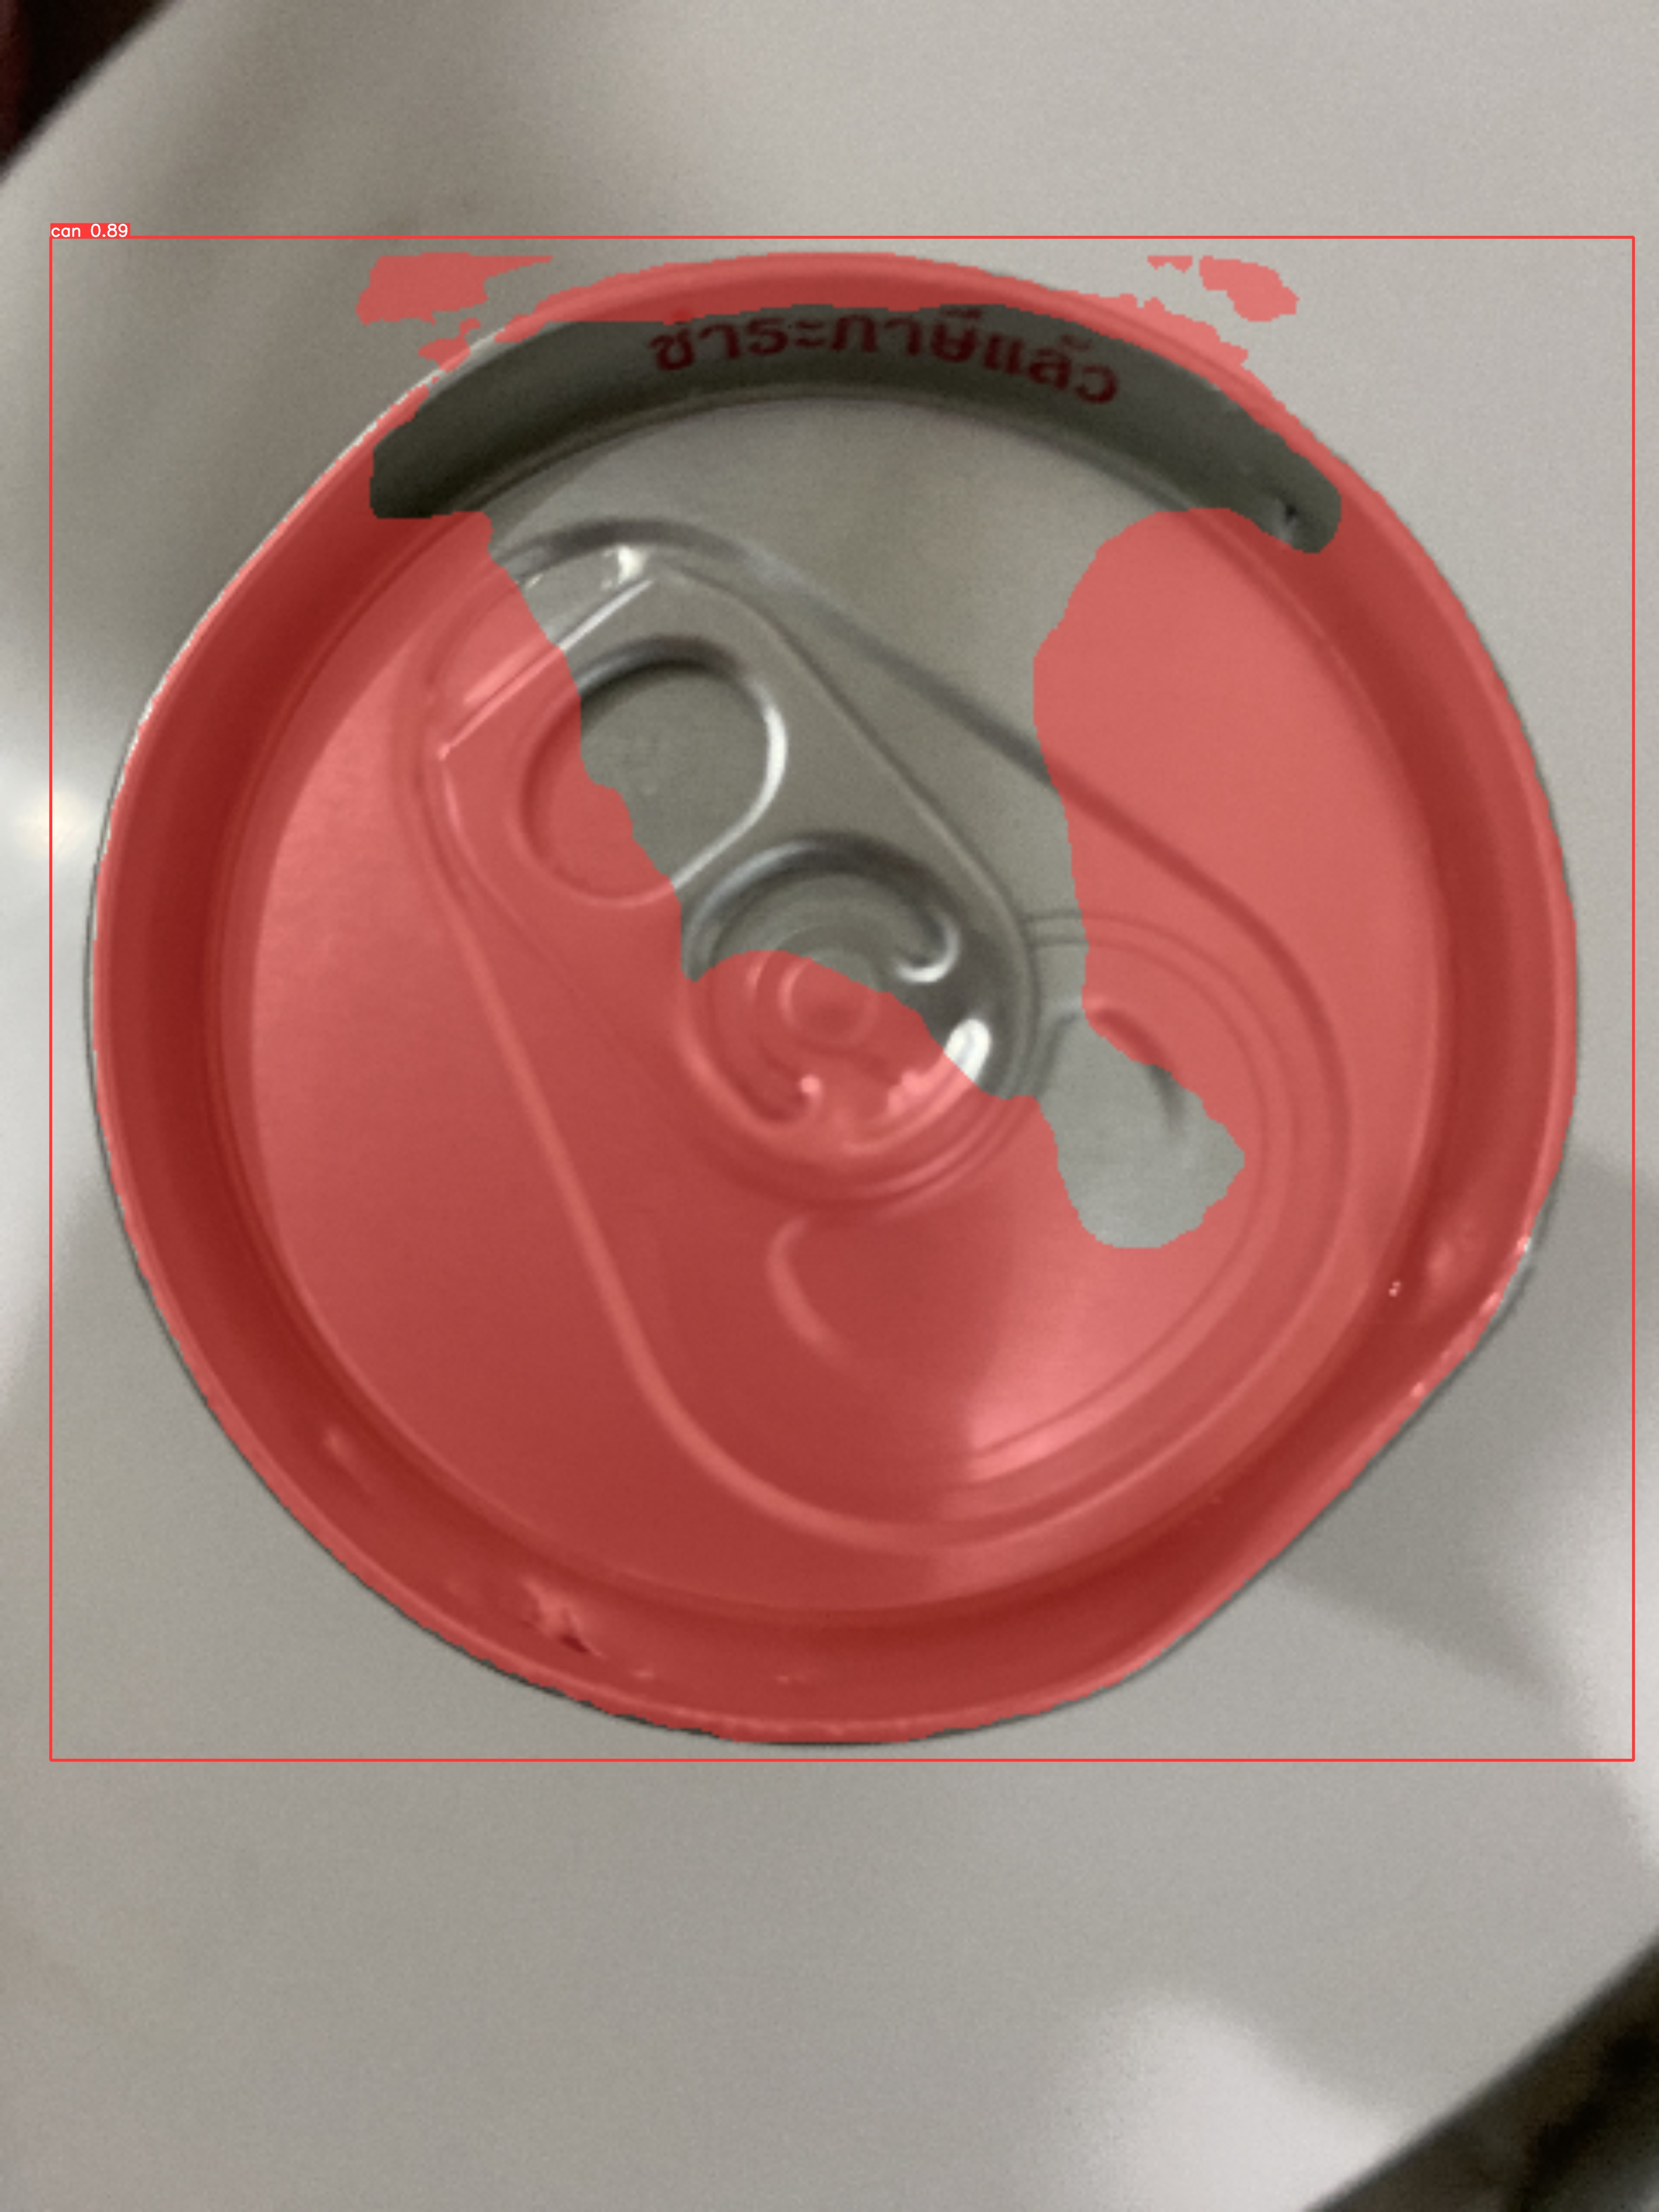

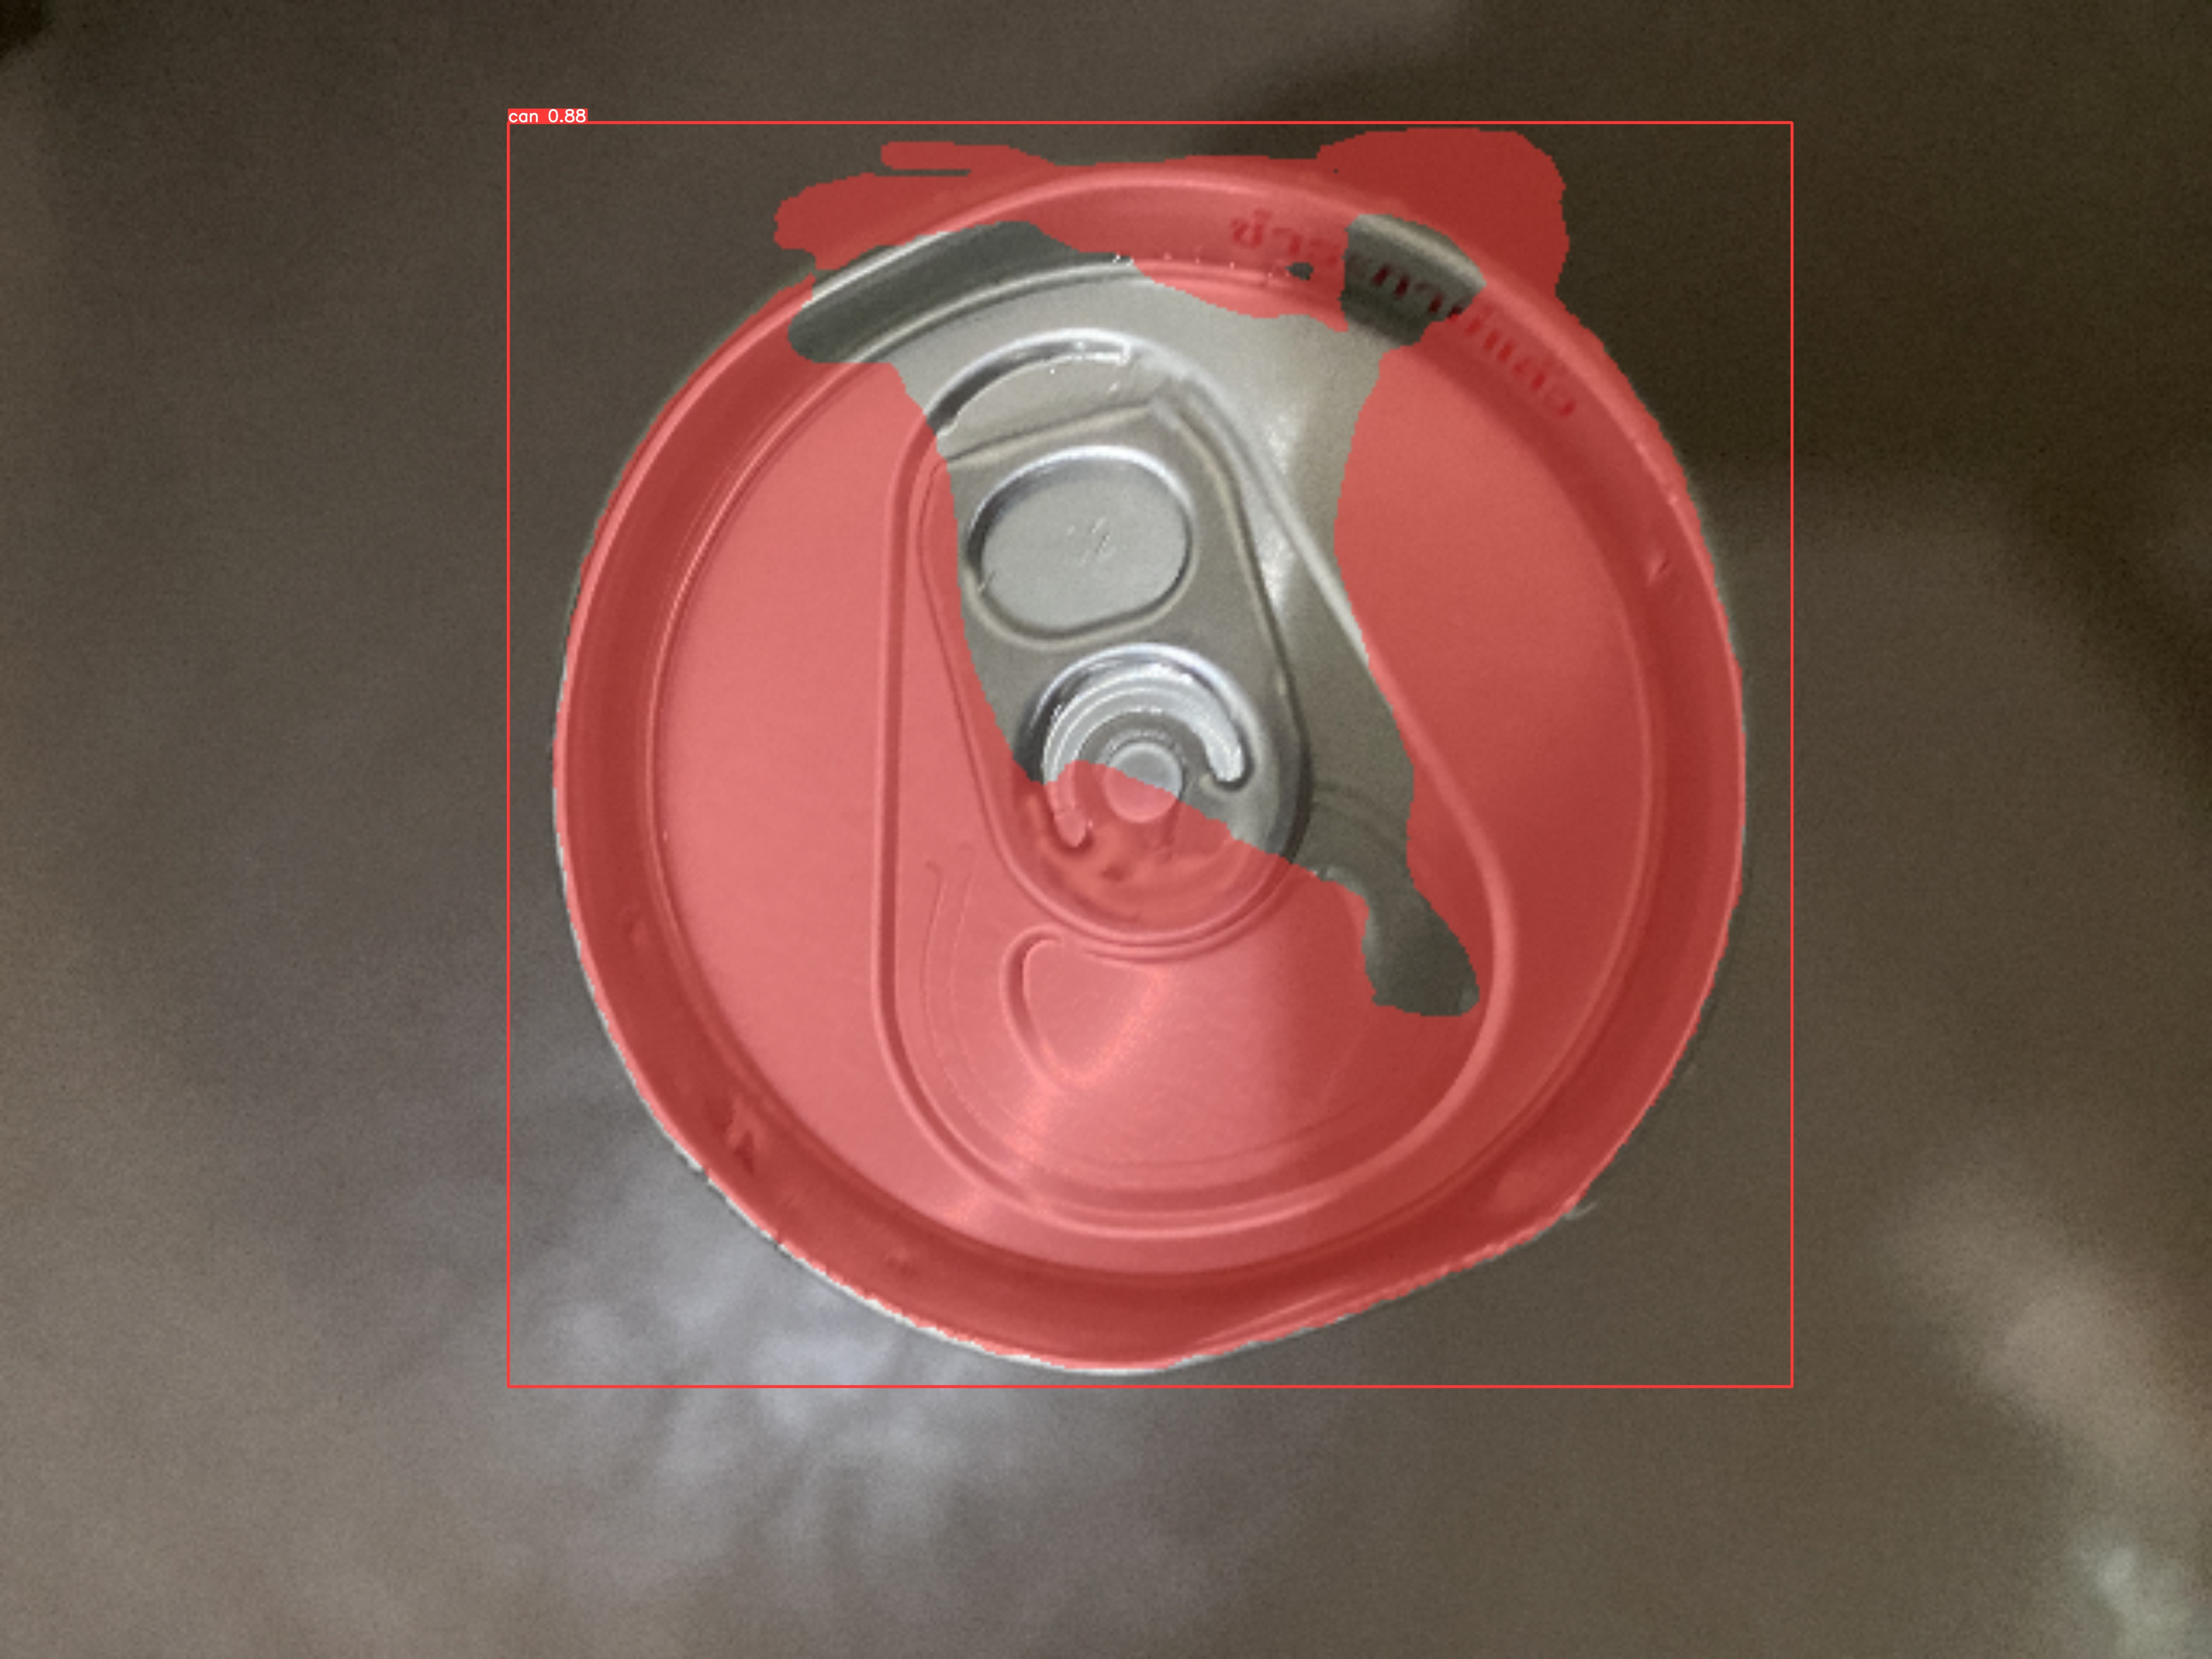

In [45]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'./runs/segment/predict/*.jpg')[:3]:
      display(Image(filename=image_path, width=600))
      print("\n")

In [46]:
Name_experimant = model_params['name']
Name_experimant


'Y2_20.5_'

In [47]:
test_picture_files = test_data['Image_path'].tolist()

print("Number of test pictures: ", len(test_picture_files))
test_picture_files[0:5]

Number of test pictures:  194


['Raw_Can_Dataset/Normal4/IMG_4358.jpg',
 'Raw_Can_Dataset/Normal4/IMG_4411.jpg',
 'Raw_Can_Dataset/Normal4/IMG_4383.jpg',
 'Raw_Can_Dataset/Normal4/IMG_4382.jpg',
 'Raw_Can_Dataset/Normal4/IMG_4402.jpg']

In [51]:
from ultralytics import YOLO
import numpy as np
import torch



model = YOLO('./runs/segment/Y2_20.5_/weights/last.pt')
model

In [52]:
device = '0' if torch.cuda.is_available() else 'cpu'
device 

'0'

In [53]:
import cv2
import matplotlib.pyplot as plt


for file in test_picture_files[0:5] :

    resutls = model.predict(file, conf=0.5,device= 'cpu')
    maskimg =resutls[0].masks.data.numpy().squeeze()


    # Load the image and mask
    img = cv2.imread(file)


    # Determine the scaling factor
    scale_factor = img.shape[0] / maskimg.shape[0]

    # Resize the binary mask image
    resized_binary_mask = cv2.resize(maskimg, None, fx=scale_factor, fy=scale_factor)
    resized_binary_mask = (resized_binary_mask*255).astype(np.uint8)


    plt.figure(figsize=(10, 8))
    # Plot the image
    plt.subplot(131)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Image')

    # Plot the mask
    plt.subplot(132)
    plt.imshow(resized_binary_mask, cmap='gray')
    plt.title('Mask')

    # Plot the mask
    plt.subplot(133)
    plt.imshow(cv2.bitwise_and(img.copy(), img.copy(), mask=resized_binary_mask), cmap='gray')
    plt.title('Mask')
    
    plt.show()


Ultralytics YOLOv8.0.28 🚀 Python-3.10.10 torch-2.0.0 CPU
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs

image 1/1 /home/ubuntu/yolo/Raw_Can_Dataset/Normal4/IMG_4358.jpg: 640x480 369.7ms
Speed: 0.8ms pre-process, 369.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


AttributeError: 'NoneType' object has no attribute 'data'

In [39]:
resutls

[Ultralytics YOLO <class 'ultralytics.yolo.engine.results.Boxes'> masks
 type: <class 'torch.Tensor'>
 shape: torch.Size([0, 6])
 dtype: torch.float32
  + tensor([], size=(0, 6))]